In [24]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
import jax.numpy as jnp
import jax.scipy as scipy
import numpy as np

import optax

from data.data import Mcycle

from typing import Sequence, Any

import flax.linen as nn
from flax.core import unfreeze
from tinygp import GaussianProcess, kernels
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import regdata as rd

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

# from jax.config import config
# config.update("jax_enable_x64", True)

rc("animation", html='jshtml')

Data loaded
Fold 0: MSLL = 0.14237797260284424, RMSE = 0.4498054087162018, NLPD = 5.426445007324219
Fold 1: MSLL = 0.2954922318458557, RMSE = 0.41388508677482605, NLPD = 6.130037307739258
Fold 2: MSLL = 0.8753951191902161, RMSE = 0.5571597814559937, NLPD = 13.140628814697266
Fold 3: MSLL = 0.24895219504833221, RMSE = 0.3619798719882965, NLPD = 5.48084831237793
Fold 4: MSLL = -0.08046373724937439, RMSE = 0.43814021348953247, NLPD = -0.9989986419677734
Mean msll = 0.2963507562875748Mean RMSE = 0.4441940724849701Mean NLPD = 5.835792160034179
Finished


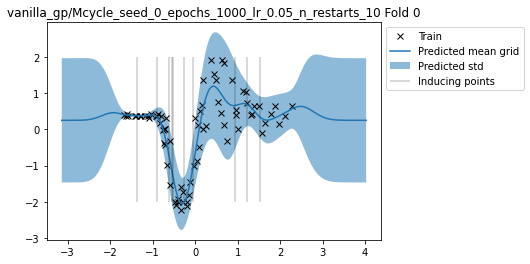

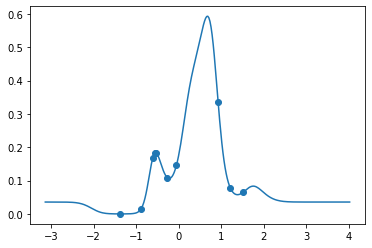

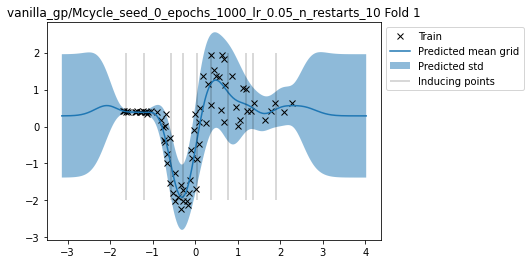

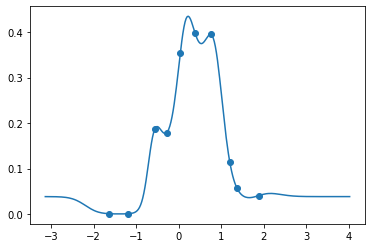

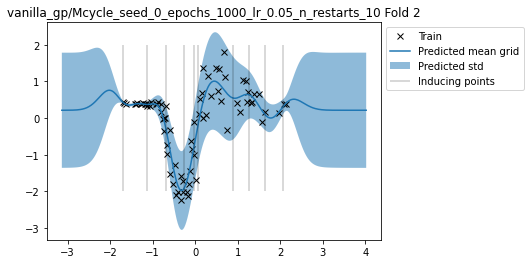

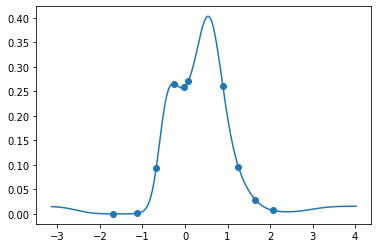

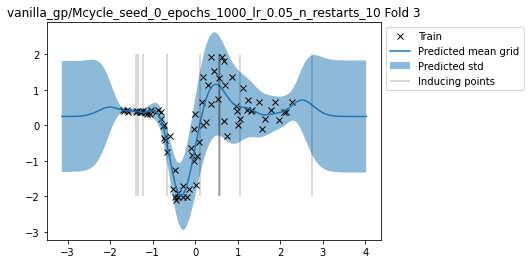

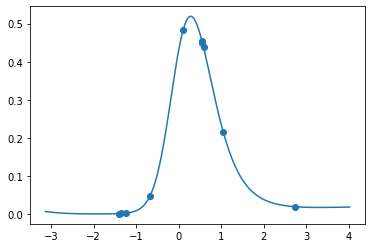

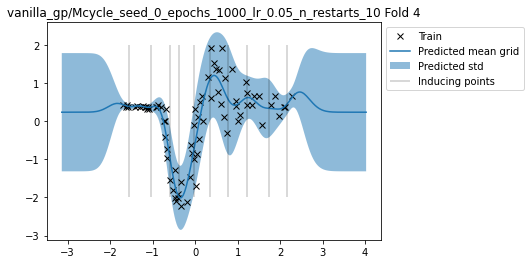

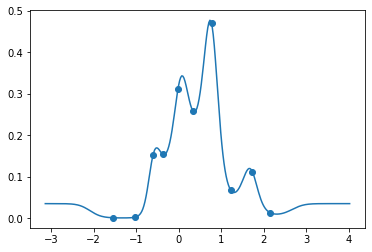

In [25]:
####################################
method = "vanilla_gp"
# method = "dkl_tinygp"

features = [16, 8, 4, 2]  # for dkl

data_obj = Mcycle()
data = data_obj()

variance_prior = tfd.TransformedDistribution(tfd.Gamma(0.5, 1.0), tfb.Log())
lengthscale_prior = tfd.TransformedDistribution(tfd.Gamma(5.0, 1.0), tfb.Log())

# data_obj = rd.SineJump1D()
# X, y, X_test = data_obj.get_data()

# X = jnp.linspace(0.1,19.9,100)
# y = jnp.sign(jnp.sin(X))
# X_test = jnp.linspace(0.1,19.9,200)

########## GPflow dataset
# N = 1001

# np.random.seed(0)
# # tf.random.set_seed(0)

# # Build inputs X
# X = np.linspace(0, 4 * np.pi, N)[:, None]  # X must be of shape [N, 1]
# X_test = np.linspace(0, 4*np.pi, 2*N)[:, None]
# # Deterministic functions in place of latent ones
# f1 = np.sin
# f2 = np.cos

# # Use transform = exp to ensure positive-only scale values
# transform = np.exp

# # Compute loc and scale as functions of input X
# loc = f1(X)
# scale = transform(f2(X))

# # Sample outputs Y from Gaussian Likelihood
# y = np.random.normal(loc, scale).ravel()

# data = {
#     "n_folds": 1,
#     "X_grid": X_test,
#     "folds": {
#         0: {
#             "X_train": X,
#             "X_test": X_test,
#             "y_train": y,
#             "y_test": jnp.zeros(X_test.shape[0]),
#             "X_inducing": X[::5],
#         }
#     },
# }

seed = 0
n_restarts = 10
num_epochs = 1000
lr = 0.05
optimizer = optax.adam(lr)
add_penalty = False
add_inducing_value_prior = True

save_name = f"{method}/{data_obj.__class__.__name__}_seed_{seed}_epochs_{num_epochs}_lr_{lr}_n_restarts_{n_restarts}"
####################################

if method == "vanilla_gp":

    def noise_gp_predict(params, X):
        kernel = jnp.exp(params["inducing_gp_log_var"]) * kernels.ExpSquared(
            scale=jnp.exp(params["inducing_gp_log_scale"])
        )
        gp = GaussianProcess(
            kernel=kernel,
            X=params["X_inducing"],
            diag=1e-3,  # jnp.exp(params["inducing_gp_log_noise"]),
            mean=params["inducing_gp_mean"],
        )
        log_inducing_noise = (
            params["inducing_gp_mean"]
            + jnp.linalg.cholesky(gp.covariance) @ params["std_inducing_noise"]
        )
        pred_gp = gp.condition(
            log_inducing_noise,
            X,
            diag=1e-3,  # jnp.exp(params["inducing_gp_log_noise"]),
        ).gp
        covar = pred_gp.covariance  # + 1e-3 * jnp.eye(X.shape[0])
        return (
            jnp.exp(pred_gp.mean.ravel()),
            jnp.log(jnp.diag(jnp.linalg.cholesky(covar))).sum(),
        )

    def get_gp(params, X):
        kernel = jnp.exp(params["log_var"]) * kernels.ExpSquared(
            scale=jnp.exp(params["log_scale"])
        )
        noise, penalty = noise_gp_predict(params, X)
        gp = GaussianProcess(kernel=kernel, X=X, diag=noise, mean=params["mean"])
        return gp, penalty

    def loss_fn(params, X, y):
        gp, penalty = get_gp(params, X)
        loss = -gp.log_probability(y)
        if add_penalty:
            loss += penalty
        if add_inducing_value_prior:
            prior = tfd.Normal(0.0, 1.0)
            loss -= prior.log_prob(params["std_inducing_noise"]).sum()
            prior = variance_prior
            loss -= prior.log_prob(params["inducing_gp_log_var"]).sum()
            prior = lengthscale_prior
            loss -= prior.log_prob(params["inducing_gp_log_scale"]).sum()
        return loss

    def initialize_params(key, X, X_inducing):
        array = jax.random.normal(key, (3,))
        log_scale, log_var, mean = array
        key = jax.random.split(key, num=1)[0]
        std_inducing_noise = jax.random.normal(key, (X_inducing.shape[0],))
        
        prior = variance_prior
        key = jax.random.split(key, num=1)[0]
        inducing_gp_log_var = prior.sample(seed=key)
        prior = lengthscale_prior
        key = jax.random.split(key, num=1)[0]
        inducing_gp_log_scale = prior.sample(seed=key)        
        inducing_gp_log_noise = jnp.nan
        
        key = jax.random.split(key, num=1)[0]
        inducing_gp_mean = jax.random.normal(key)
        
        return {
            "X_inducing": X_inducing,
            "log_scale": log_scale,
            "log_var": log_var,
            "mean": mean,
            "std_inducing_noise": std_inducing_noise,
            "inducing_gp_log_scale": inducing_gp_log_scale,
            "inducing_gp_log_var": inducing_gp_log_var,
            "inducing_gp_log_noise": inducing_gp_log_noise,
            "inducing_gp_mean": inducing_gp_mean,
        }

    def predict(X, y, X_eval, params):
        gp, _ = get_gp(params, X)
        noise, _ = noise_gp_predict(params, X_eval)
        new_gp = gp.condition(y, X_eval, diag=noise).gp
        return new_gp.mean, new_gp.covariance

elif method == "dkl_tinygp":

    class MLP(nn.Module):
        features: Sequence[int] = (1,)
        activation: Any = nn.relu

        @nn.compact
        def __call__(self, x):
            for feature in self.features[:-1]:
                x = nn.Dense(feature)(x)
                x = self.activation(x)
            x = nn.Dense(self.features[-1])(x)
            return x

    mlp = MLP(features=features)

    def get_gp(params, X):
        nn_params, gp_params = params
        warped_X = mlp.apply(nn_params, X)
        kernel = jnp.exp(gp_params["log_var"]) * kernels.ExpSquared(
            scale=jnp.exp(gp_params["log_scale"])
        )
        gp = GaussianProcess(
            kernel=kernel,
            X=warped_X,
            diag=jnp.exp(gp_params["log_noise"]),
            mean=gp_params["mean"],
        )
        return gp

    def loss_fn(params, X, y):
        gp = get_gp(params, X)
        return -gp.log_probability(y)

    def initialize_params(key, X):
        keys = jax.random.split(key, 2)
        nn_params = unfreeze(mlp.init(keys[0], X))
        array = jax.random.normal(keys[1], (4,))
        log_scale, log_var, log_noise, mean = array
        return nn_params, {
            "log_scale": log_scale,
            "log_var": log_var,
            "log_noise": log_noise,
            "mean": mean,
        }

    def predict(X, y, X_eval, params):
        gp = get_gp(params, X)
        noise = jnp.exp(params["log_noise"])
        new_gp = gp.condition(y, X_eval, diag=noise).gp
        return new_gp.mean, new_gp.covariance


def training_fn(key, X, y, X_inducing):
    params = initialize_params(key, X, X_inducing)
    state = optimizer.init(params)
    loss_fn_in = jax.tree_util.Partial(loss_fn, X=X, y=y)

    @jax.jit
    def step(params_and_state, aux):
        params, state = params_and_state
        loss, grads = jax.value_and_grad(loss_fn_in)(params)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state), (params, loss)

    (params, state), (params_history, loss_history) = jax.lax.scan(
        f=step, init=(params, state), xs=None, length=num_epochs
    )
    return {
        "params": params,
        "params_history": params_history,
        "loss_history": loss_history,
    }


def train_and_predict_fold(i):
    key = jax.random.PRNGKey(seed)
    keys = jax.random.split(key, num=n_restarts)
    training_fn_in = jax.tree_util.Partial(
        training_fn,
        X=data["folds"][i]["X_train"],
        y=data["folds"][i]["y_train"],
        X_inducing=data["folds"][i]["X_inducing"],
    )
    result = jax.vmap(training_fn_in)(keys)

    best_restart = jnp.argmin(result["loss_history"][:, -1])
    best_result = jax.tree_util.tree_map(lambda x: x[best_restart], result)

    pred_mean, pred_covar = predict(
        data["folds"][i]["X_train"],
        data["folds"][i]["y_train"],
        data["folds"][i]["X_test"],
        best_result["params"],
    )

    pred_mean_grid, pred_covar_grid = predict(
        data["folds"][i]["X_train"],
        data["folds"][i]["y_train"],
        data["X_grid"],
        best_result["params"],
    )

    pred_noise, _ = noise_gp_predict(best_result["params"], data["X_grid"])

    #     pred_covar = pred_covar + 1e-3 * jnp.eye(pred_covar.shape[0])
    #     print(jnp.diag(pred_covar)**0.5)
    msll = -scipy.stats.norm.logpdf(
        data["folds"][i]["y_test"].ravel(),
        pred_mean.ravel(),
        jnp.diag(pred_covar) ** 0.5,
    ).mean()
    nlpd = -tfd.MultivariateNormalFullCovariance(pred_mean.ravel(), pred_covar).log_prob(data["folds"][i]["y_test"].ravel())
    rmse = jnp.sqrt(
        jnp.mean((pred_mean.ravel() - data["folds"][i]["y_test"].ravel()) ** 2)
    )

    print(f"Fold {i}: MSLL = {msll}, RMSE = {rmse}, NLPD = {nlpd}")
    return {
        "nlpd":nlpd,
        "msll": msll,
        "rmse": rmse,
        "pred_mean": pred_mean,
        "pred_covar": pred_covar,
        "pred_mean_grid": pred_mean_grid,
        "pred_covar_grid": pred_covar_grid,
        "pred_noise": pred_noise,
        "best_result": best_result,
    }


result = jax.tree_util.tree_map(
    lambda i: train_and_predict_fold(i), list(range(data["n_folds"]))
)
print(
    f"Mean msll = {np.mean(list(map(lambda x: x['msll'].item(), result)))}" 
    f"Mean RMSE = {np.mean(list(map(lambda x: x['rmse'].item(), result)))}"
    f"Mean NLPD = {np.mean(list(map(lambda x: x['nlpd'].item(), result)))}"
)

for fold_i in range(data["n_folds"]):
    plt.figure()
    params = result[fold_i]["best_result"]["params"]
    plt.plot(
        data["folds"][fold_i]["X_train"],
        data["folds"][fold_i]["y_train"],
        "x",
        label="Train",
        color="k",
    )
#     plt.scatter(
#         data["folds"][fold_i]["X_test"],
#         result[fold_i]["pred_mean"],
#         label="Predicted mean",
#     )
#     plt.scatter(
#         data["folds"][fold_i]["X_test"], data["folds"][fold_i]["y_test"], label="Test"
#     )
    plt.plot(
        data["X_grid"], result[fold_i]["pred_mean_grid"], label="Predicted mean grid"
    )
    plt.fill_between(
        data["X_grid"].ravel(),
        result[fold_i]["pred_mean_grid"].ravel()
        - 2 * jnp.diag(result[fold_i]["pred_covar_grid"]).ravel() ** 0.5,
        result[fold_i]["pred_mean_grid"].ravel()
        + 2 * jnp.diag(result[fold_i]["pred_covar_grid"]).ravel() ** 0.5,
        alpha=0.5,
        label="Predicted std",
    )
    plt.vlines(params["X_inducing"], -2, 2, label="Inducing points", color="k", alpha=0.2)
    plt.title(save_name + " Fold " + str(fold_i))
    plt.legend(bbox_to_anchor=(1, 1))
#     plt.ylim(-4, 4)
    #     plt.savefig(save_name + "_fold_" + str(fold_i) + ".png")
    plt.figure()
    plt.plot(data["X_grid"], result[fold_i]["pred_noise"], label="Predicted noise")
    kernel = jnp.exp(params["inducing_gp_log_var"]) * kernels.ExpSquared(
        scale=jnp.exp(params["inducing_gp_log_scale"])
    )
    gp = GaussianProcess(
        kernel=kernel,
        X=params["X_inducing"],
        diag=1e-3,  # jnp.exp(params["inducing_gp_log_noise"]),
        mean=params["inducing_gp_mean"],
    )
    stdnoise = params["std_inducing_noise"]
    log_inducing_noise = (
        params["inducing_gp_mean"] + jnp.linalg.cholesky(gp.covariance) @ stdnoise
    )
    plt.scatter(
        params["X_inducing"],
        jnp.exp(log_inducing_noise),
        label="Noise inducing points",
    )
#     plt.savefig(save_name + "_fold_" + str(fold_i) + "_noise.png")

print("Finished")

## Previous best

# Fold 0: MSLL = 0.14237797260284424, RMSE = 0.4498054087162018, NLPD = 5.426445007324219
# Fold 1: MSLL = 0.2954922318458557, RMSE = 0.41388508677482605, NLPD = 6.130037307739258
# Fold 2: MSLL = 0.8753951191902161, RMSE = 0.5571597814559937, NLPD = 13.140628814697266
# Fold 3: MSLL = 0.24895219504833221, RMSE = 0.3619798719882965, NLPD = 5.48084831237793
# Fold 4: MSLL = -0.08046373724937439, RMSE = 0.43814021348953247, NLPD = -0.9989986419677734
# Mean msll = 0.2963507562875748Mean RMSE = 0.4441940724849701Mean NLPD = 5.835792160034179

In [16]:
fold = 0
x = jnp.linspace(-5, 5, 100)
history = result[fold_i]["best_result"]["params_history"]

fig,ax = plt.subplots()

def get_prediction(params):
    kernel = jnp.exp(params["inducing_gp_log_var"]) * kernels.Matern52(
                scale=jnp.exp(params["inducing_gp_log_scale"])
    gp = GaussianProcess(kernel=kernel, X=params["X_inducing"], diag=1e-3, mean=params["inducing_gp_mean"])
    noise_pred = gp.condition(params["log_inducing_noise"], x).gp.mean
    return params["X_inducing"].ravel(), params["log_inducing_noise"].ravel(), noise_pred.ravel()

X_ind, ind_noise, noise_preds = jax.vmap(get_prediction)(history)

def update(i):
    ax.cla()
    ax.scatter(X_ind[i], ind_noise[i]);
    ax.plot(x, noise_preds[i]);
    ax.set_xlim(-5,5)

anim = FuncAnimation(fig, update, range(num_epochs), cache_frame_data=False)
plt.close()
anim

ValueError: x and y must have same first dimension, but have shapes (282, 1) and (100,)

In [13]:
fold = 0
history = result[fold]["best_result"]["params_history"]
params = result[fold]["best_result"]["params"]
params
# result[fold]["best_result"]["loss_history"]

{'X_inducing': DeviceArray([[-3.47416253],
              [-1.59996099],
              [-0.64435237],
              [-0.92671673],
              [-0.22851643],
              [-0.2549895 ],
              [ 0.55565216],
              [ 1.03309294],
              [ 1.73852914],
              [ 1.93509284]], dtype=float64),
 'inducing_gp_log_noise': DeviceArray(-1.62793003, dtype=float64),
 'inducing_gp_log_scale': DeviceArray(0.47720482, dtype=float64),
 'inducing_gp_log_var': DeviceArray(1.49931635, dtype=float64),
 'inducing_gp_mean': DeviceArray(-4.55886959, dtype=float64),
 'log_scale': DeviceArray(-1.07095618, dtype=float64),
 'log_var': DeviceArray(-0.34615245, dtype=float64),
 'mean': DeviceArray(0.24850214, dtype=float64),
 'std_inducing_noise': DeviceArray([-1.33683795e+00, -1.36738652e-02,  2.46698281e+00,
               1.35364929e-02, -4.33270837e-02,  1.21400941e-02,
              -2.57075474e-01, -9.47277282e-02, -2.98602197e-02,
               6.52874056e-04], dtype=float64)

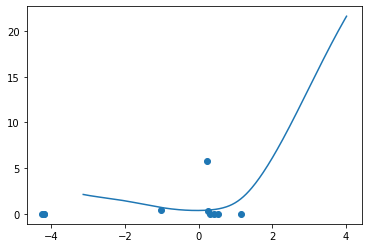

In [94]:
log_var = params["inducing_gp_log_var"]
log_scale = params["inducing_gp_log_scale"]
log_noise = 1e-3#params["inducing_gp_log_noise"]

kernel = jnp.exp(log_var) * kernels.ExpSquared(scale=jnp.exp(log_scale))
gp = GaussianProcess(kernel=kernel, X=params["X_inducing"], diag=jnp.exp(log_noise), mean=params["inducing_gp_mean"])
pred = jnp.exp(gp.condition(params["log_inducing_noise"], data["X_grid"]).gp.mean)

plt.scatter(params["X_inducing"], jnp.exp(params["log_inducing_noise"]))
plt.plot(data["X_grid"], pred);

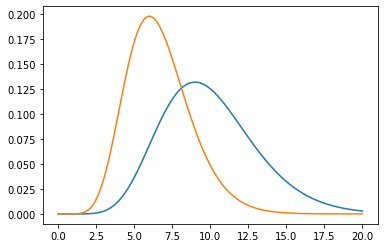

In [19]:
rng = jnp.linspace(0,20,100)

plt.plot(rng, tfd.Gamma(10, 1.0).prob(rng))
plt.plot(rng, tfd.Gamma(10, 1.5).prob(rng))